In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from scipy.stats import zscore

In [169]:
# Adjust Matplotlib parameters to handle large plots
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['path.simplify_threshold'] = 1.0

In [170]:
# Load the dataset
data = pd.read_csv('Water Quality Prediction.csv')

In [171]:
# Display basic info        
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            1019772 non-null  float64
 14  Ch

In [172]:
# Descriptive statistics
print(data.describe())

              Index            pH          Iron       Nitrate      Chloride  \
count  1.048575e+06  1.028344e+06  1.041584e+06  1.029880e+06  1.017741e+06   
mean   5.242870e+05  7.449869e+00  1.139646e-01  6.078584e+00  1.818660e+02   
std    3.026977e+05  8.478455e-01  4.433188e-01  3.131874e+00  6.576657e+01   
min    0.000000e+00  2.058008e+00  2.050000e-53  2.861727e-01  2.941350e+01   
25%    2.621435e+05  6.914812e+00  8.950000e-06  3.952811e+00  1.374347e+02   
50%    5.242870e+05  7.452940e+00  2.054149e-03  5.564798e+00  1.747464e+02   
75%    7.864305e+05  8.001406e+00  4.977795e-02  7.584930e+00  2.156446e+02   
max    1.048574e+06  1.289196e+01  1.574860e+01  7.307293e+01  1.430549e+03   

                Lead          Zinc     Turbidity      Fluoride        Copper  \
count   1.043891e+06  1.020900e+06  1.039881e+06  1.015357e+06  1.013693e+06   
mean    1.291635e-03  1.528928e+00  4.835915e-01  9.410137e-01  4.939443e-01   
std     3.030129e-02  1.505436e+00  8.614735e-01

In [173]:
# Feature Selection: Identify most relevant features
features = data.drop('Target', axis=1)
target = data['Target']

In [174]:
# Handle missing values
for col in features.columns:
    if features[col].dtype in ['int64', 'float64']:
        features[col] = features[col].fillna(features[col].mean())
    else:
        features[col] = features[col].fillna(features[col].mode()[0])

In [176]:
# Ensure 'Day' and 'Time of Day' are integers
features['Day'] = features['Day'].astype(int)
features['Time of Day'] = features['Time of Day'].astype(int)

In [177]:
# Map month names to numerical values
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
features['Month'] = features['Month'].map(month_mapping)

# Ensure 'Day' and 'Time of Day' are integers
features['Day'] = features['Day'].astype(int)
features['Time of Day'] = features['Time of Day'].astype(int)

# Create a Date column from Month, Day, and Time of Day
def create_date(row):
    month = row['Month']
    day = row['Day']
    time_of_day = row['Time of Day']
    # Construct a datetime string and convert to datetime object
    date_str = f'2021-{month:02d}-{day:02d} {time_of_day:02d}:00:00'
    return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')

features['Date'] = features.apply(create_date, axis=1)

# Drop the original time columns after creating Date
features = features.drop(columns=['Month', 'Day', 'Time of Day'])

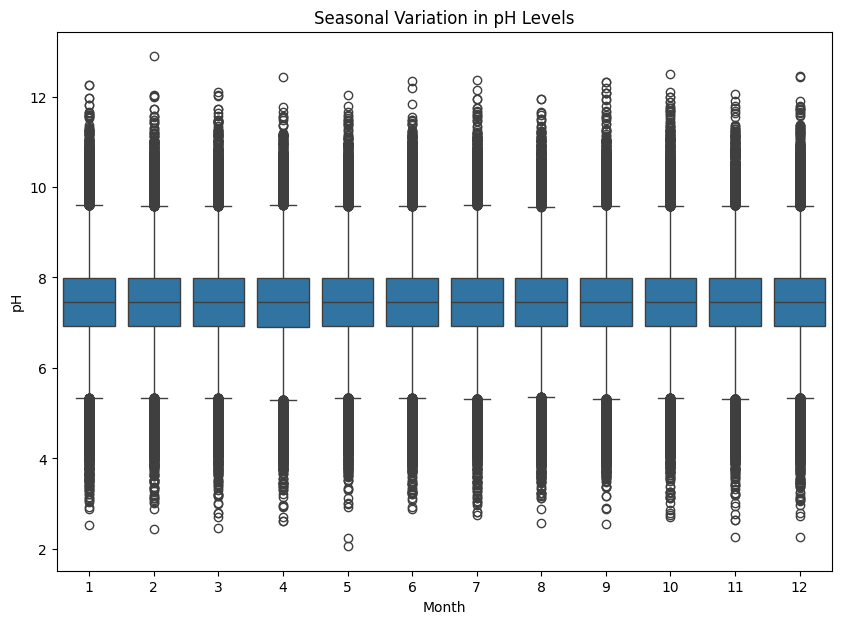

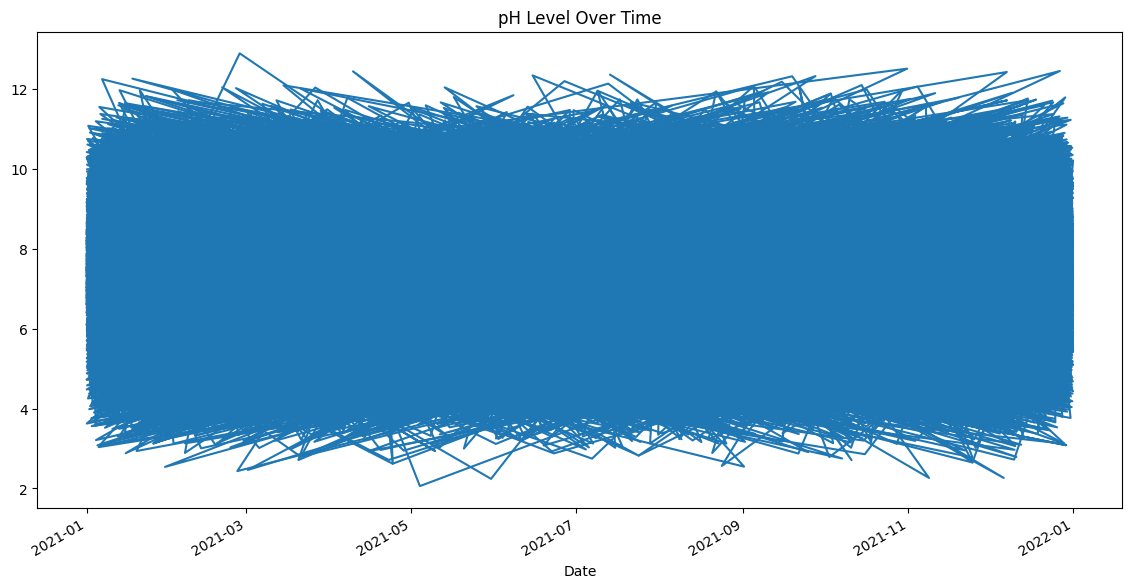

In [178]:
# Set the Date column as the index for time series analysis
features.set_index('Date', inplace=True)

# Ensure the index is a DatetimeIndex
features.index = pd.to_datetime(features.index)

# Extract the Month from the Date index
features['Month'] = features.index.month

# Plot Seasonal Patterns again
plt.figure(figsize=(10, 7))
sns.boxplot(x='Month', y='pH', data=features.reset_index())
plt.title('Seasonal Variation in pH Levels')
plt.show()

# Trend Analysis
plt.figure(figsize=(14, 7))
features['pH'].plot()
plt.title('pH Level Over Time')
plt.show()

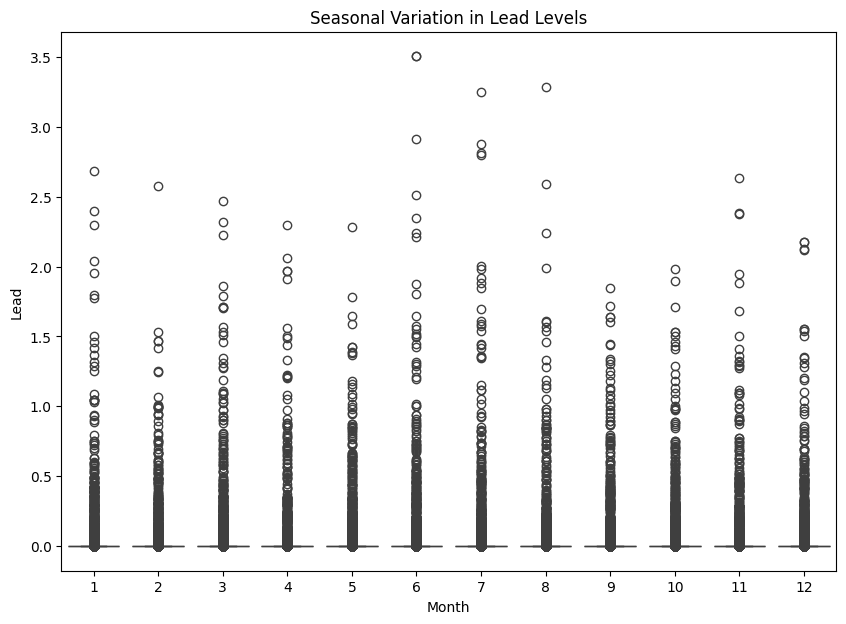

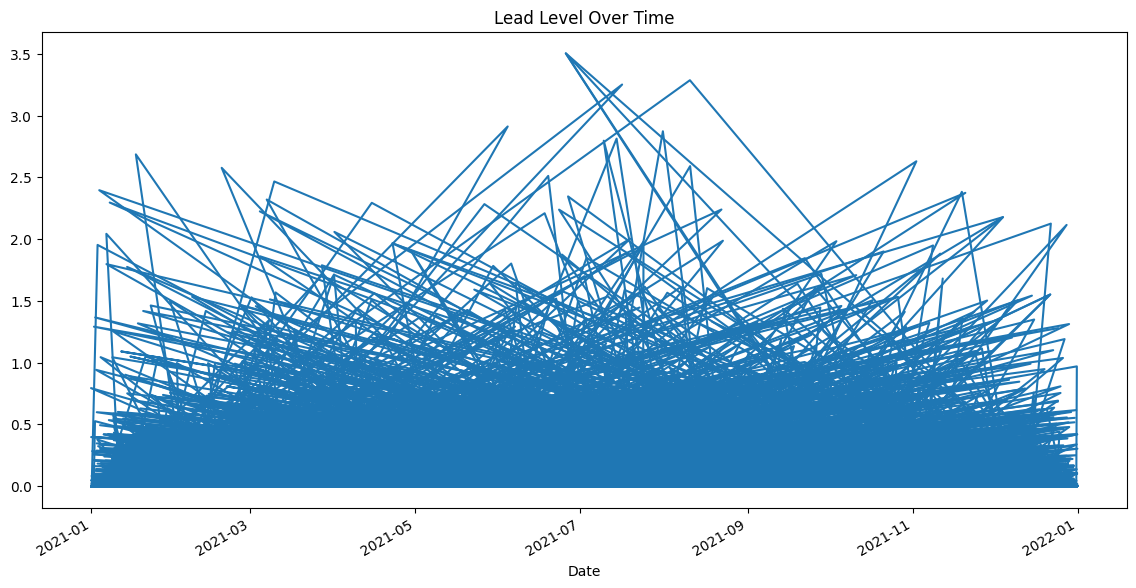

In [179]:
# Seasonal Patterns
features['Month'] = features.index.month
plt.figure(figsize=(10, 7))
sns.boxplot(x='Month', y='Lead', data=features.reset_index())
plt.title('Seasonal Variation in Lead Levels')
plt.show() 

# Trend Analysis
plt.figure(figsize=(14, 7))
features['Lead'].plot()
plt.title('Lead Level Over Time')
plt.show()

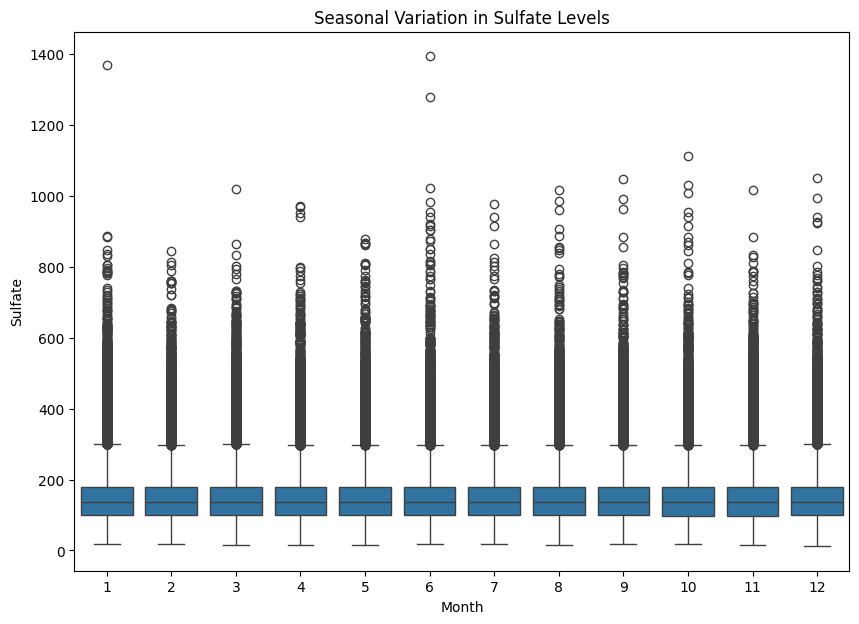

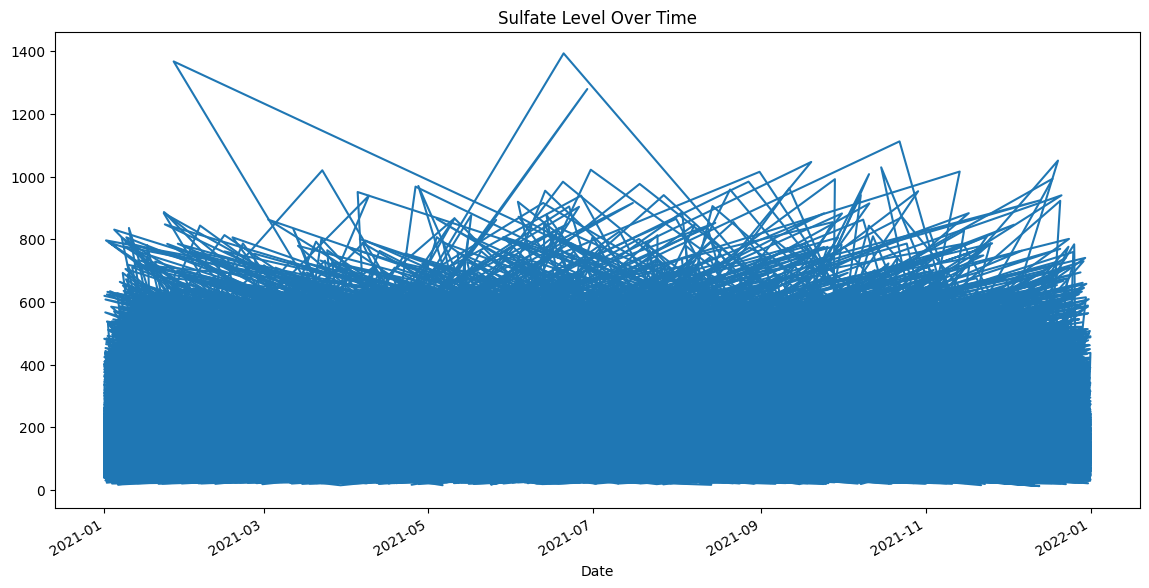

In [180]:

# Seasonal Patterns
features['Month'] = features.index.month
plt.figure(figsize=(10,7))
sns.boxplot(x='Month', y='Sulfate', data=features.reset_index())
plt.title('Seasonal Variation in Sulfate Levels')
plt.show() 

# Trend Analysis
plt.figure(figsize=(14, 7))
features['Sulfate'].plot()
plt.title('Sulfate Level Over Time')
plt.show()

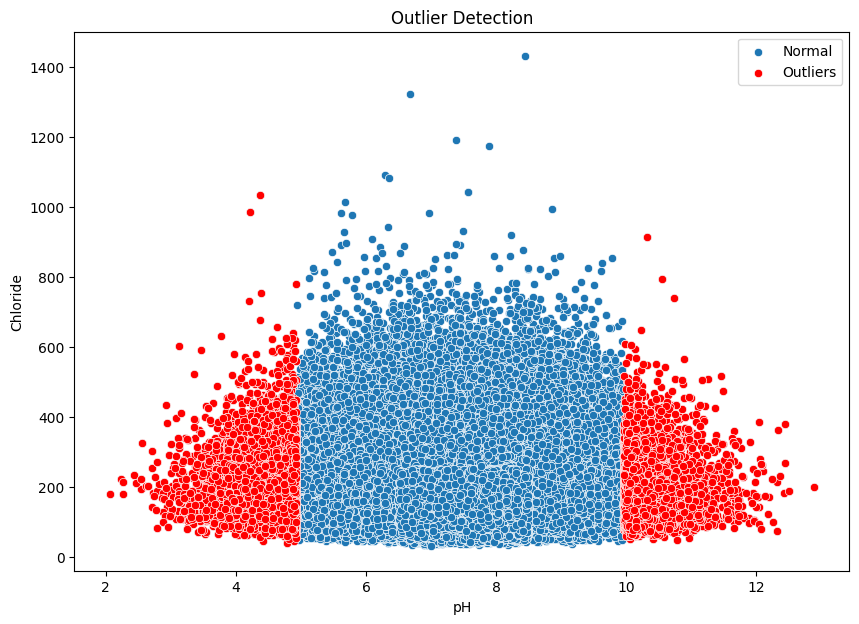

In [186]:
# Using Z-score for outlier detection
features['zscore'] = zscore(features['pH'])
outliers = features[np.abs(features['zscore']) > 3]

# Plot outliers
plt.figure(figsize=(10, 7))
sns.scatterplot(data=features, x='pH', y='Chloride', label='Normal')
sns.scatterplot(data=outliers, x='pH', y='Chloride', color='red', label='Outliers')
plt.title('Outlier Detection')
plt.show()

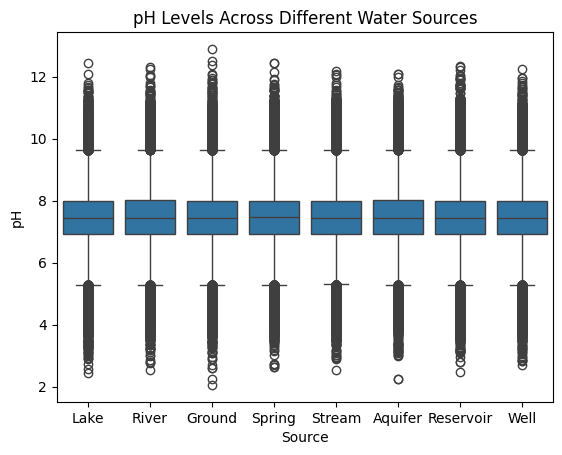

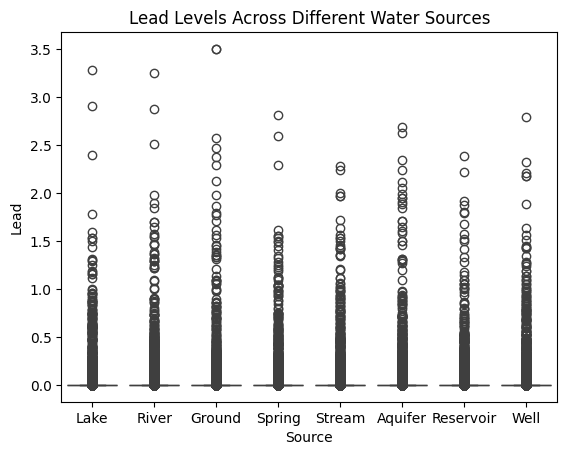

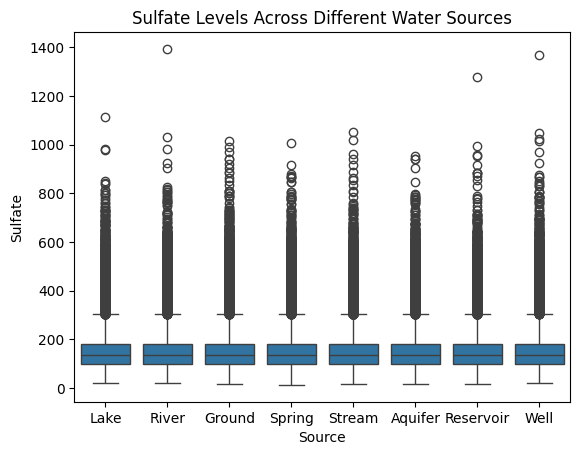

In [187]:
# Assuming 'Source' column is present in the data
sns.boxplot(x='Source', y='pH', data=data)
plt.title('pH Levels Across Different Water Sources')
plt.show() 

sns.boxplot(x='Source', y='Lead', data=data)
plt.title('Lead Levels Across Different Water Sources')
plt.show() 

sns.boxplot(x='Source', y='Sulfate', data=data)
plt.title('Sulfate Levels Across Different Water Sources')
plt.show()

In [188]:
# Handle non-numerical values (Label Encoding)
categorical_cols = features.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    features[col] = features[col].astype(str)
    features[col] = le.fit_transform(features[col])
    label_encoders[col] = le


In [189]:
# Handle missing values
for col in features.columns:
    if features[col].dtype in ['int64', 'float64']:
        features[col] = features[col].fillna(features[col].mean())
    else:
        features[col] = features[col].fillna(features[col].mode()[0])

In [190]:
# Normalize or standardize the numerical features
numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

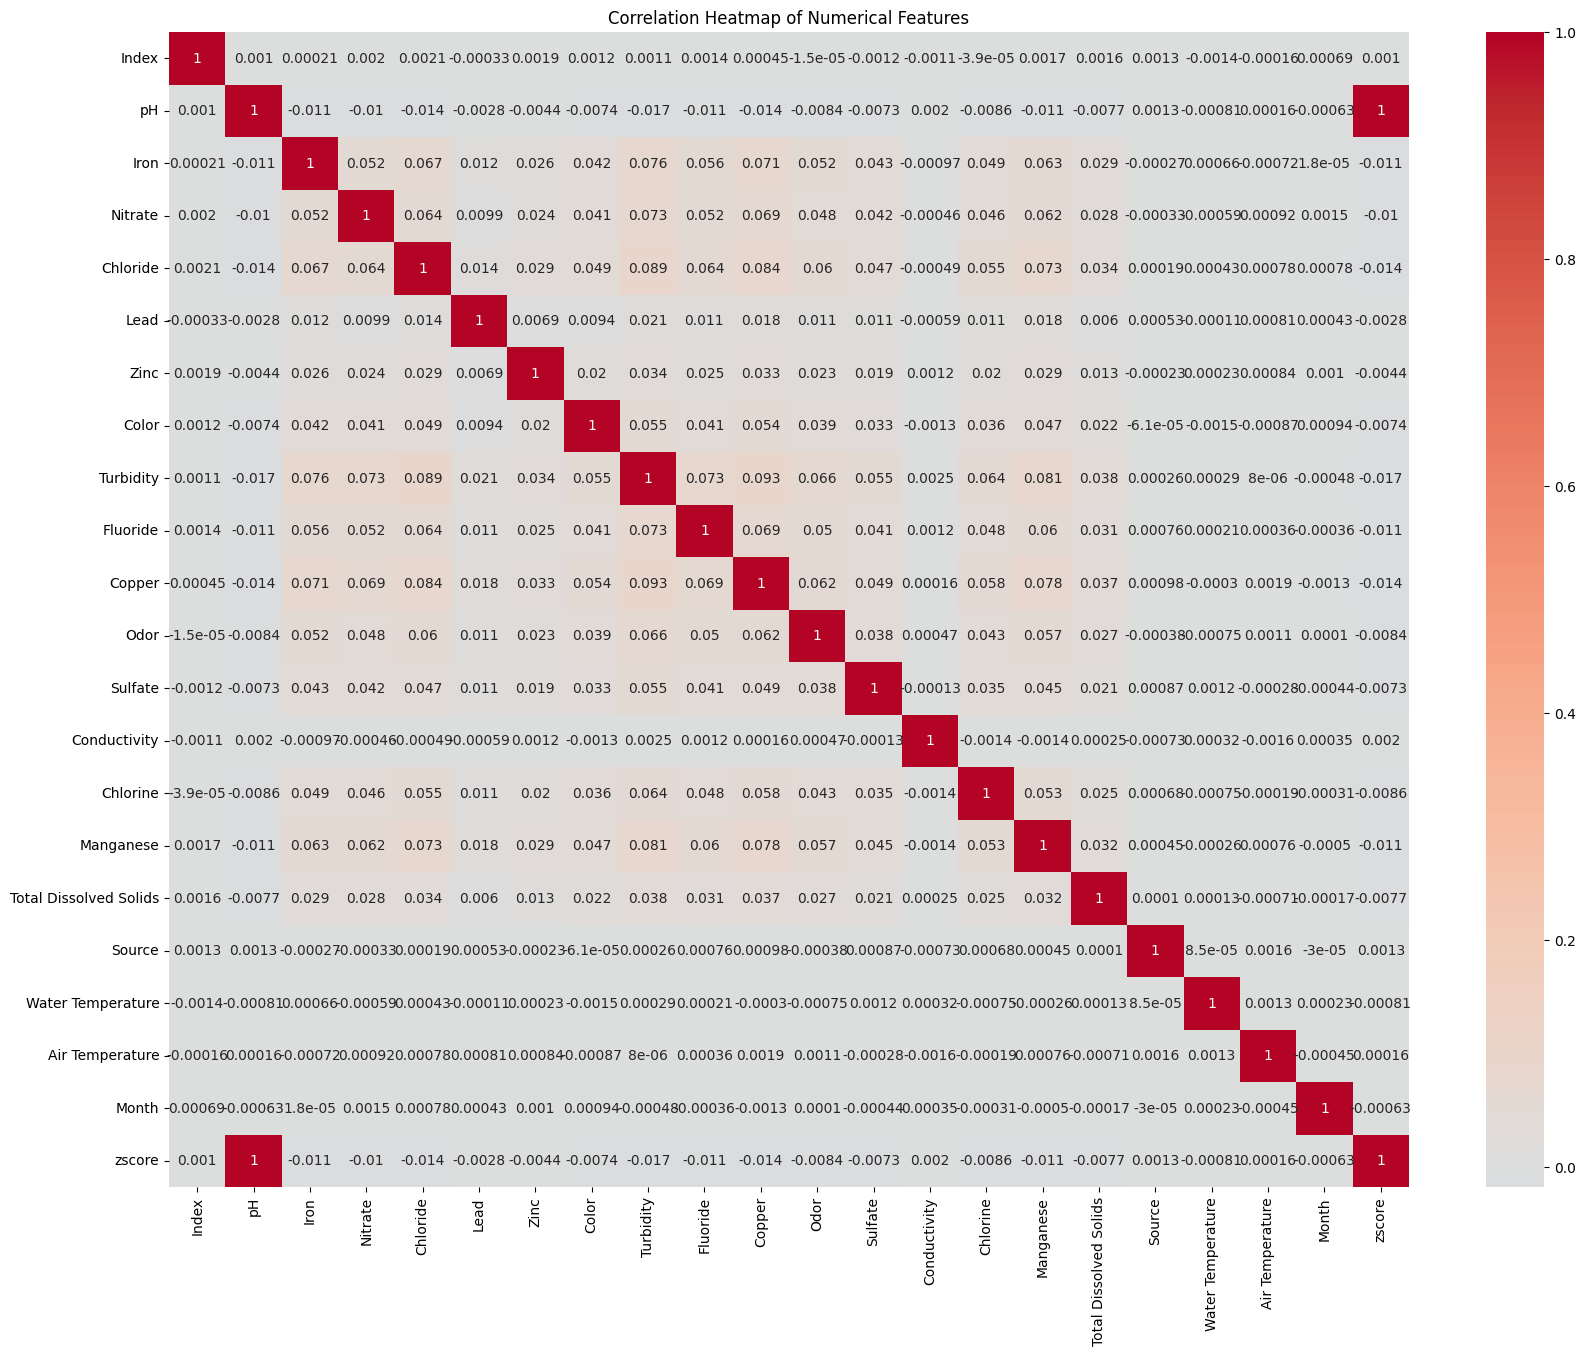

In [191]:
# Correlation Matrix and Heatmap
plt.figure(figsize=(20, 15))
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [192]:
print(features.head())

                        Index        pH      Iron   Nitrate  Chloride  \
Date                                                                    
2021-01-29 04:00:00 -1.732049  1.051800 -0.257744  0.814218 -0.911623   
2021-11-26 16:00:00 -1.732046 -0.633623 -0.257751 -0.755331  0.697055   
2021-01-31 08:00:00 -1.732043 -2.389286 -0.212428 -0.728645  0.758263   
2021-04-01 21:00:00 -1.732039  0.602017  0.067951  0.691520 -0.057662   
2021-06-29 07:00:00 -1.732036  0.764673 -0.253028  1.239503  0.072152   

                         Lead      Zinc     Color  Turbidity  Fluoride  ...  \
Date                                                                    ...   
2021-01-29 04:00:00 -0.042722  1.283057 -1.195319  -0.537255 -0.427949  ...   
2021-11-26 16:00:00 -0.042722 -0.190928 -0.477780  -0.541540 -0.407957  ...   
2021-01-31 08:00:00 -0.042722 -0.673640  0.239759  -0.190741 -0.663717  ...   
2021-04-01 21:00:00 -0.042722  1.682302  0.957298  -0.369827 -0.939377  ...   
2021-06-29 07:

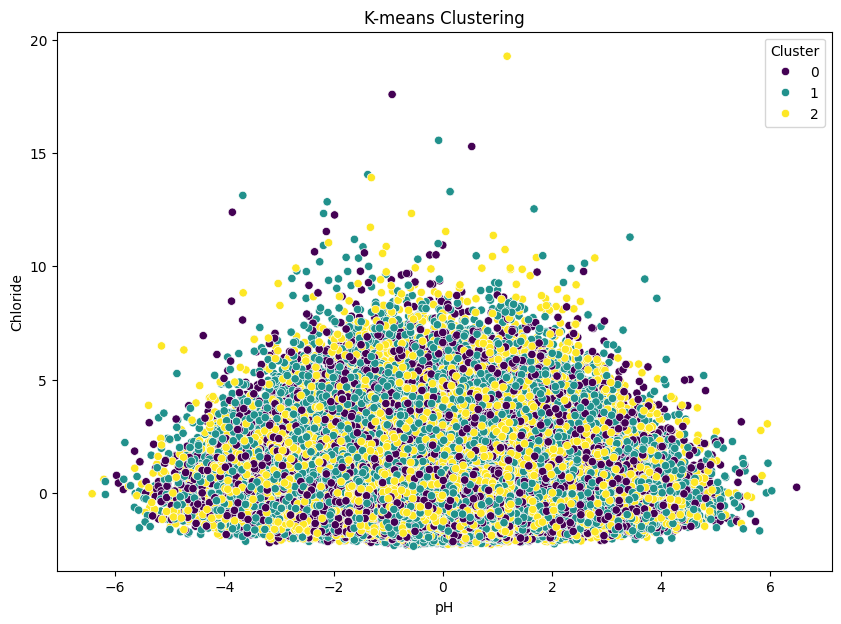

In [193]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features['Cluster'] = kmeans.fit_predict(features)

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=features, x='pH', y='Chloride', hue='Cluster', palette='viridis')
plt.title('K-means Clustering')
plt.show()

In [194]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [195]:
# Train a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [196]:
# Predict on the test set
y_pred = model.predict(X_test)

In [197]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [198]:
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9970054597906682
Confusion Matrix:
[[161033    577]
 [    51  48054]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    161610
           1       0.99      1.00      0.99     48105

    accuracy                           1.00    209715
   macro avg       0.99      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



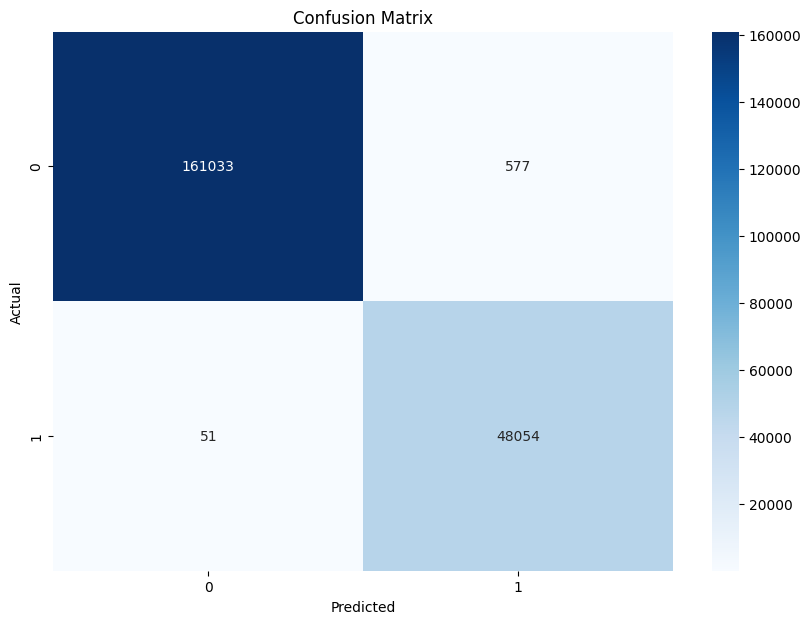

In [199]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()